In [53]:
import os
import numpy as np
from nibabel.testing import data_path
import nibabel as nib
d_r = '/home/plant99/Documents/code/pro_per/a-t-b/data/nii-data/Outputs/cpac/filt_global/alff_extracted'
e_f = os.path.join(d_r, 'Caltech_0051456_alff.nii')
print(e_f)
img = nib.load(e_f)




/home/plant99/Documents/code/pro_per/a-t-b/data/nii-data/Outputs/cpac/filt_global/alff_extracted/Caltech_0051456_alff.nii


In [59]:
x = np.array(img.get_fdata())

type(x)

numpy.ndarray

In [55]:
img.shape

(61, 73, 61)

In [64]:
from nilearn import plotting
from nilearn import image

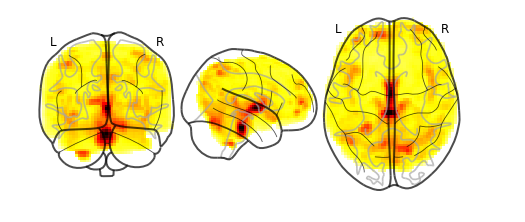

In [70]:
x = plotting.plot_glass_brain(e_f) 

In [63]:
x

In [13]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from nibabel.testing import data_path
import nibabel as nib
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
plt.ion()   # interactive mode

d_r = '/home/plant99/Documents/code/pro_per/a-t-b/data/nii-data/Outputs/cpac/filt_global/png-i'

In [14]:
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001


In [3]:
class Rescale(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size
    
    def __call__(self, sample):
        image = sample['image']
        h, w = image.shape[:2]
        
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size
        
        new_h, new_w = int(new_h), int(new_w)
        
        img = transform.resize(image, (new_h, new_w))
        return {'image': img, 'label': sample['label']}
class ToTensor(object):

    def __call__(self, sample):
        image = sample['image']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image), 'label': sample['label']}

In [ ]:
class DS(Dataset):
    def __init__(self, csv_file, transform = None):
        self.transform = transform
        self.csv_ds = pd.read_csv(csv_file, dtype='str')
#         self.root_dir = root_dir
    
    def __len__(self):
        return len(self.csv_ds)
    
    def __getitem__(self, idx):
        print(self.csv_ds.iloc[idx]['FILE_ID'],self.csv_ds.iloc[idx]['DX_GROUP'] )
        e_f = os.path.join(d_r, self.csv_ds.iloc[idx]['FILE_ID']+'_alff.nii.jpg')
        
#         if self.csv_ds.iloc[idx]['FILE_ID'] == "no_filename":
#             e_f = os.path.join(d_r, 'Olin_0050130_alff.nii')
        img = io.imread(e_f)
#         img_name = str(self.csv_ds.iloc[idx][0])
#         img_path = os.path.join(self.root_dir, 'train',str(self.csv_ds.iloc[idx][1]), str(self.csv_ds.iloc[idx][0]) + '.jpg')
#         image = io.imread(img_path)
        label = self.csv_ds.iloc[idx]['DX_GROUP']
        sample = {'image': img, 'label': label}
        
        if self.transform:
            sample = self.transform(sample)
        return sample
#         return("asd")
    


In [11]:
tds = DS(csv_file='./data/data.csv',
                                    transform = transforms.Compose([ToTensor()]) )
import time
fig = plt.figure()
scale = Rescale((100, 100))
toTensor = ToTensor()

for i in range(len(tds)):
    
    sample = tds[i]
#     print(i, sample['image'].shape, sample['label'])
#     np_i = sample['image'].numpy()
#     io.imshow(np.transpose(np_i, (1, 2, 0)), interpolation='nearest')
#     tensor_image = toTensor(sample)['image']
#     scaled_image = scale(sample)['image']
#     io.imshow(scaled_image)
#     ax = plt.subplot(1, 4, i + 1)
#     plt.tight_layout()
#     ax.set_title('Sample #{}'.format(i))
#     ax.axis('off')
# #     show_landmarks(**sample)

#     if i == 2:
# #         plt.show()
#         break
#     time.sleep(2)

Pitt_0050003 1
Pitt_0050004 1
Pitt_0050005 1
Pitt_0050006 1
Pitt_0050007 1
Pitt_0050008 1
Pitt_0050009 1
Pitt_0050010 1
Pitt_0050011 1
Pitt_0050012 1
Pitt_0050013 1
Pitt_0050014 1
Pitt_0050015 1
Pitt_0050016 1
Pitt_0050017 1
Pitt_0050019 1
Pitt_0050020 1
Pitt_0050022 1
Pitt_0050023 1
Pitt_0050024 1
Pitt_0050025 1
Pitt_0050026 1
Pitt_0050027 1
Pitt_0050028 1
Pitt_0050029 1
Pitt_0050030 2
Pitt_0050031 2
Pitt_0050032 2
Pitt_0050033 2
Pitt_0050034 2
Pitt_0050035 2
Pitt_0050036 2
Pitt_0050037 2
Pitt_0050038 2
Pitt_0050039 2
Pitt_0050040 2
Pitt_0050041 2
Pitt_0050042 2
Pitt_0050043 2
Pitt_0050044 2
Pitt_0050045 2
Pitt_0050046 2
Pitt_0050047 2
Pitt_0050048 2
Pitt_0050049 2
Pitt_0050050 2
Pitt_0050051 2
Pitt_0050052 2
Pitt_0050053 1
Pitt_0050054 2
Pitt_0050055 1
Pitt_0050056 1
Pitt_0050057 1
Pitt_0050058 2
Pitt_0050059 2
Pitt_0050060 2
Olin_0050102 2
Olin_0050103 2
Olin_0050104 2
Olin_0050105 2
Olin_0050106 2
Olin_0050107 2
Olin_0050109 2
Olin_0050110 2
Olin_0050111 2
Olin_0050112 2
Olin_00501

Leuven_2_0050745 1
Leuven_2_0050746 1
Leuven_2_0050747 1
Leuven_2_0050748 1
Leuven_2_0050749 1
Leuven_2_0050750 1
Leuven_2_0050751 1
Leuven_2_0050752 1
Leuven_2_0050753 1
Leuven_2_0050754 1
Leuven_2_0050755 1
Leuven_2_0050756 1
Leuven_2_0050757 1
KKI_0050772 2
KKI_0050773 2
KKI_0050774 2
KKI_0050775 2
KKI_0050776 2
KKI_0050777 2
KKI_0050778 2
KKI_0050779 2
KKI_0050780 2
KKI_0050781 2
KKI_0050782 2
KKI_0050783 2
KKI_0050784 2
KKI_0050785 2
KKI_0050786 2
KKI_0050787 2
KKI_0050788 2
KKI_0050789 2
KKI_0050790 2
KKI_0050791 1
KKI_0050792 1
KKI_0050793 1
KKI_0050794 1
KKI_0050795 1
KKI_0050796 1
KKI_0050797 1
KKI_0050798 1
KKI_0050799 1
KKI_0050800 1
KKI_0050801 1
KKI_0050802 1
KKI_0050803 1
KKI_0050804 1
KKI_0050807 1
KKI_0050812 2
KKI_0050814 2
KKI_0050815 1
KKI_0050816 2
KKI_0050817 2
KKI_0050818 2
KKI_0050819 2
KKI_0050820 2
KKI_0050821 2
KKI_0050822 2
KKI_0050823 1
KKI_0050824 1
KKI_0050825 1
KKI_0050826 1
NYU_0050952 1
NYU_0050954 1
NYU_0050955 1
NYU_0050956 1
NYU_0050957 1
NYU_0050958

<Figure size 432x288 with 0 Axes>